# Predicting COVID-19 Using CT Scans

## Load the Data

In [1]:
## Imports ## 

import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
#Check if there's a GPU available 
tf.config.experimental.list_physical_devices('GPU')

[]

In [3]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(loss)+1)

    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, color = 'orange', label='Training Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.legend()
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, color = 'orange', label='Training Accuracy')
    plt.plot(epochs, val_acc, color = 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.show();

Load the image data:

In [4]:
data = []
file_list = []
y = []

for png in os.listdir("../data/CT_COVID"):
    pic = plt.imread("../data/CT_COVID/" + png, 0)
    data.append(pic)
    file_list.append(png)
    y.append(1)

for png in os.listdir("../data/CT_NonCOVID"):
    pic = plt.imread("../data/CT_NonCOVID/" + png, 0)
    data.append(pic)
    file_list.append(png)
    y.append(0)

In [5]:
metadata = pd.read_excel("../data/COVID-CT-MetaInfo.xlsx", header = None, names = ['file','patient','column3','note'])

Look at the data:

Case and Control Counts: 
Case
0    397
1    349
Name: Case, dtype: int64


Example Image with COVID: 


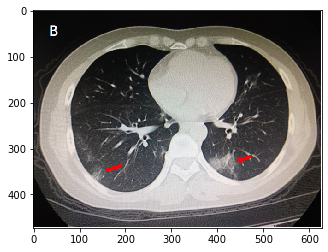

Example Image without COVID: 


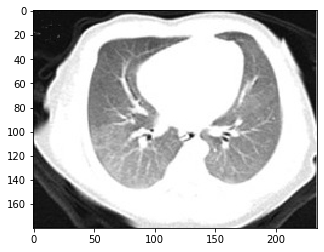

In [6]:
print("Case and Control Counts: ")
print(pd.DataFrame(y, columns = ['Case']).groupby("Case").Case.count())

print("\n")

print("Example Image with COVID: ")
plt.imshow(data[1]); plt.show();

print("Example Image without COVID: ")
plt.imshow(data[501], cmap = 'gray'); plt.show();

In [7]:
metadata.head() #note: checked that these are in the same order as the file list; for covid-19 patients only 

,file,patient,column3,note
0,2020.01.24.919183-p27-132.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
1,2020.01.24.919183-p27-133.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
2,2020.01.24.919183-p27-134.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
3,2020.01.24.919183-p27-135.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
4,2020.02.10.20021584-p6-52%0.png,Patient 2,NaN,['Figure 1. A 50-year-old man with 2019 novel ...


In [8]:
metadata.loc[metadata.patient == 'Patient 1'] #Some patients have multiple images.

,file,patient,column3,note
0,2020.01.24.919183-p27-132.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
1,2020.01.24.919183-p27-133.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
2,2020.01.24.919183-p27-134.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
3,2020.01.24.919183-p27-135.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....


## Data Processing

Investigate the size of the images:

In [9]:
print("All images have different shapes, including # of channels: ")
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)
print(data[4].shape)

#Get a list of all the sizes
shape = []
for img in data:
    shape.append(img.shape)

print(pd.DataFrame([len(s) for s in shape], columns = ['len']).groupby('len').size()) #There are 2-D and 3-D images

print((pd.DataFrame([s[0] for s in shape], columns = ['height'])).describe()) #avg 302, min 61
print((pd.DataFrame([s[1] for s in shape], columns = ['width'])).describe()) #avg 425, min 115

All images have different shapes, including # of channels: 
(473, 627, 3)
(406, 572, 4)
(98, 115, 4)
(278, 417)
len
2     44
3    702
dtype: int64
            height
count   746.000000
mean    302.553619
std     145.210573
min      61.000000
25%     204.000000
50%     291.000000
75%     363.750000
max    1225.000000
             width
count   746.000000
mean    425.482574
std     188.546038
min     115.000000
25%     311.250000
50%     407.000000
75%     512.000000
max    1671.000000


All of the images need to be the same size. Use the average size of the image from the investigation above. Use high quality down-sampling filter to resize images. Also, turn all images to black and white.

In [10]:
image_dim = (300, 400) #use the averages for the dimensions

data_cleaned = []

for img in data:
    #First, take the mean of the 3rd dimension (channels) if it exists
    if len(img.shape) == 3:
        img = np.mean(img, axis = 2)
    
    #Using PIL Image processor, resize using high quality down-sampling filter 
    img = Image.fromarray(img)
    img = img.resize((image_dim[1], image_dim[0]), Image.ANTIALIAS)
    img = np.array(img)
    
    #Normalize image values
    img = img/255
    
    data_cleaned.append(img)

data_cleaned = np.array(data_cleaned)
data_cleaned = np.expand_dims(data_cleaned,axis = 3)

Take a look at a few images and confirm that we have not lost too much information.

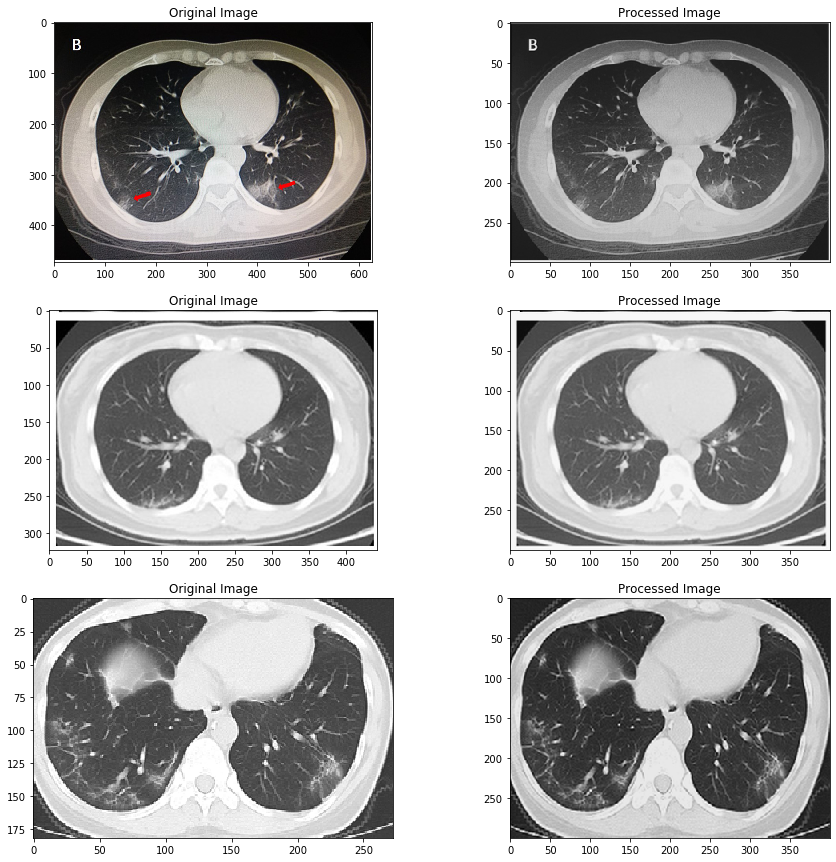

In [11]:

plt.figure(figsize = (15, 15))
plt.subplot(3,2,1)
plt.imshow(data[1], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,2)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[1]), cmap = 'gray')

plt.subplot(3,2,3)
plt.imshow(data[11], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,4)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[11]), cmap = 'gray')

plt.subplot(3,2,5)
plt.imshow(data[40], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,6)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[40]), cmap = 'gray')

plt.show();

Note that we can still see the ground glass opacities in the upper right (image 1), middle right (image 2) and bottom left (image 3).

## Data Augmentation

First, split into the test and training set. We only want to augment the training data.

In [12]:
data_train, data_val, y_train, y_val = train_test_split(data_cleaned, np.array(y),\
                                                        train_size = 0.75, random_state = 10)

In [13]:
print(str((y_val.sum() / len(y_val) )*100) + "% of our validation data is cases")

47.05882352941176% of our validation data is cases


In [14]:
print("Training Sample Sizes: ")
print(data_train.shape)
print(y_train.shape)
print("Validation Sample Sizes: ")
print(data_val.shape)
print(y_val.shape)

Training Sample Sizes: 
(559, 300, 400, 1)
(559,)
Validation Sample Sizes: 
(187, 300, 400, 1)
(187,)


Because we have a very small sample size, we want to augment our available data. We will flip all of the images horizontally and vertically.

In [15]:
#Flip horizontally
horiz_flip = tf.image.flip_left_right(data_train) 
#Flip vertically
vert_flip = tf.image.flip_up_down(data_train)

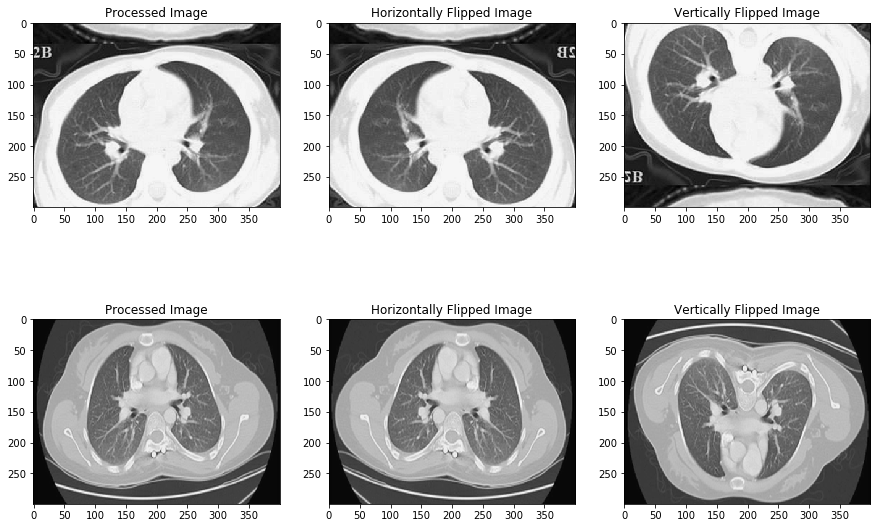

In [16]:
plt.figure(figsize = (15, 10))
plt.subplot(2,3,1)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_train[6]), cmap = 'gray')
plt.subplot(2,3,2)
plt.title("Horizontally Flipped Image")
plt.imshow(np.squeeze(horiz_flip[6]), cmap = 'gray')
plt.subplot(2,3,3)
plt.title("Vertically Flipped Image")
plt.imshow(np.squeeze(vert_flip[6]), cmap = 'gray')

plt.subplot(2,3,4)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_train[4]), cmap = 'gray')
plt.subplot(2,3,5)
plt.title("Horizontally Flipped Image")
plt.imshow(np.squeeze(horiz_flip[4]), cmap = 'gray')
plt.subplot(2,3,6)
plt.title("Vertically Flipped Image")
plt.imshow(np.squeeze(vert_flip[4]), cmap = 'gray')

plt.show();

Also considered other data augmentation, such as random rotations, zoom, brightness, and shifting, but these methods did not seem appropriate given the structure of a lung CT scan, where all images will all be centered in the same location (and thus, shifting/zooming/rotating would degrade the quality of the image). Brightness may be appropriate (perhaps reassess later).

Combine the augmented data into a single dataset:

In [17]:
data_train_augmented = np.concatenate((data_train, horiz_flip, vert_flip), axis = 0)
y_train_augmented = np.concatenate((y_train,y_train,y_train), axis = 0)

In [18]:
print("Training Sample Sizes: ")
print(data_train_augmented.shape)
print(y_train_augmented.shape)
print("Validation Sample Sizes: ")
print(data_val.shape)
print(y_val.shape)

Training Sample Sizes: 
(1677, 300, 400, 1)
(1677,)
Validation Sample Sizes: 
(187, 300, 400, 1)
(187,)


## Train a Very Simple CNN

The very simple model below gets to ~85% accuracy and takes < 5 min to train on a GPU. While training, I noticed that the model starts to really overfit after epoch 5, so I cut it off there.

It's not clear what's causing the determination -- it's possible that it's because our non-COVID cases are all lung tumors/smokers/etc... something to look into.

In [19]:
model = Sequential(name = 'Simple_CNN')
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(300, 400, 1)))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

Model: "Simple_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 400, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 200, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 200, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 100, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 128)       1

In [20]:
#Results when training the model on the randomly shuffled data
history = model.fit(
        data_train_augmented,
        y_train_augmented,
        epochs=6,
        batch_size = 16, 
        validation_data=(data_val, y_val))

Train on 1677 samples, validate on 187 samples
Epoch 1/6
1677/1677 [==============================] - 402s 240ms/sample - loss: 0.7714 - accuracy: 0.6166 - val_loss: 0.5712 - val_accuracy: 0.5989
Epoch 2/6
1677/1677 [==============================] - 362s 216ms/sample - loss: 0.5420 - accuracy: 0.7108 - val_loss: 0.4936 - val_accuracy: 0.7861
Epoch 3/6
1677/1677 [==============================] - 375s 223ms/sample - loss: 0.4391 - accuracy: 0.7996 - val_loss: 0.4611 - val_accuracy: 0.8075
Epoch 4/6
1677/1677 [==============================] - 367s 219ms/sample - loss: 0.3715 - accuracy: 0.8342 - val_loss: 0.4204 - val_accuracy: 0.7807
Epoch 5/6
1677/1677 [==============================] - 357s 213ms/sample - loss: 0.2854 - accuracy: 0.8849 - val_loss: 0.5187 - val_accuracy: 0.8182
Epoch 6/6
1677/1677 [==============================] - 360s 215ms/sample - loss: 0.2217 - accuracy: 0.9100 - val_loss: 0.5818 - val_accuracy: 0.7914


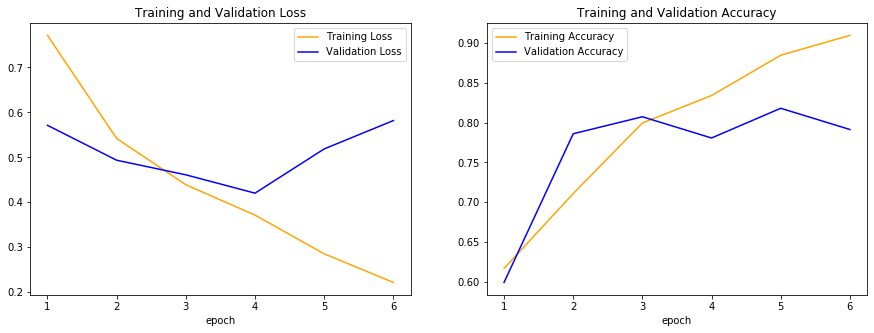

In [21]:
plot_training_history(history)

## Look at the Predictions

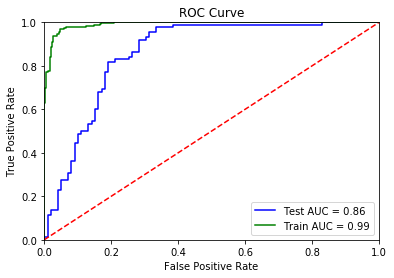

Test AUC = 0.8605
Train AUC = 0.9907


In [22]:
### Plot the training and test ROC Curves ###

#Metrics for Testing Data
probs_test = model.predict(data_val)
preds_test = probs_test.reshape(-1)
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_val, preds_test)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

#Metrics for Training Data
probs_train = model.predict(data_train)
preds_train = probs_train.reshape(-1)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, preds_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

#Plot
plt.title('ROC Curve')
plt.plot(fpr_test, tpr_test, 'b', label = 'Test AUC = %0.2f' % roc_auc_test)
plt.plot(fpr_train, tpr_train, 'g', label = 'Train AUC = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

#Training and Test AUCs
print('Test AUC = %0.4f' % roc_auc_test)
print('Train AUC = %0.4f' % roc_auc_train)


## Visualizing the Model

First, we visualize some of the intermediate activation layers:

In [23]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(np.expand_dims(data_val[1],0))

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 300, 400, 64)


In [24]:
activations[1].shape

(1, 150, 200, 64)

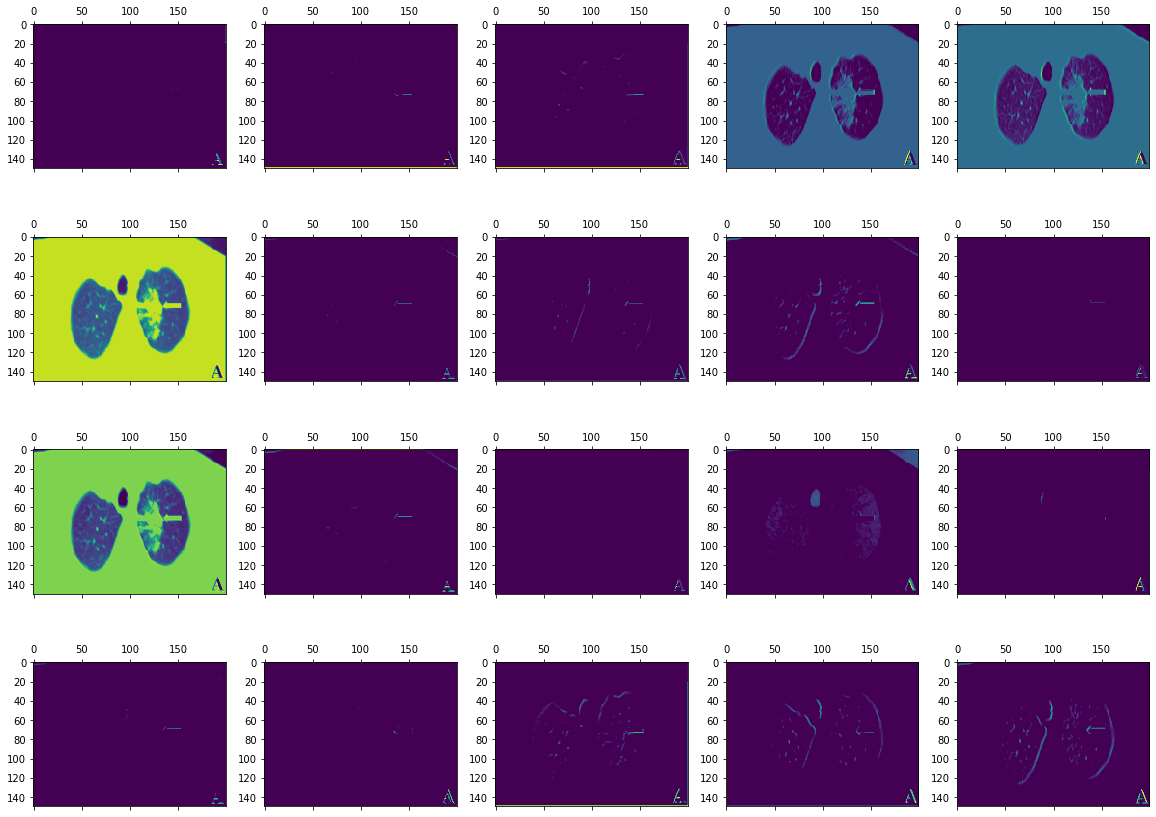

In [25]:
plt.figure(figsize = (20,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.matshow(activations[1][0, :, :, i], cmap = 'viridis', fignum = False)

plt.show();

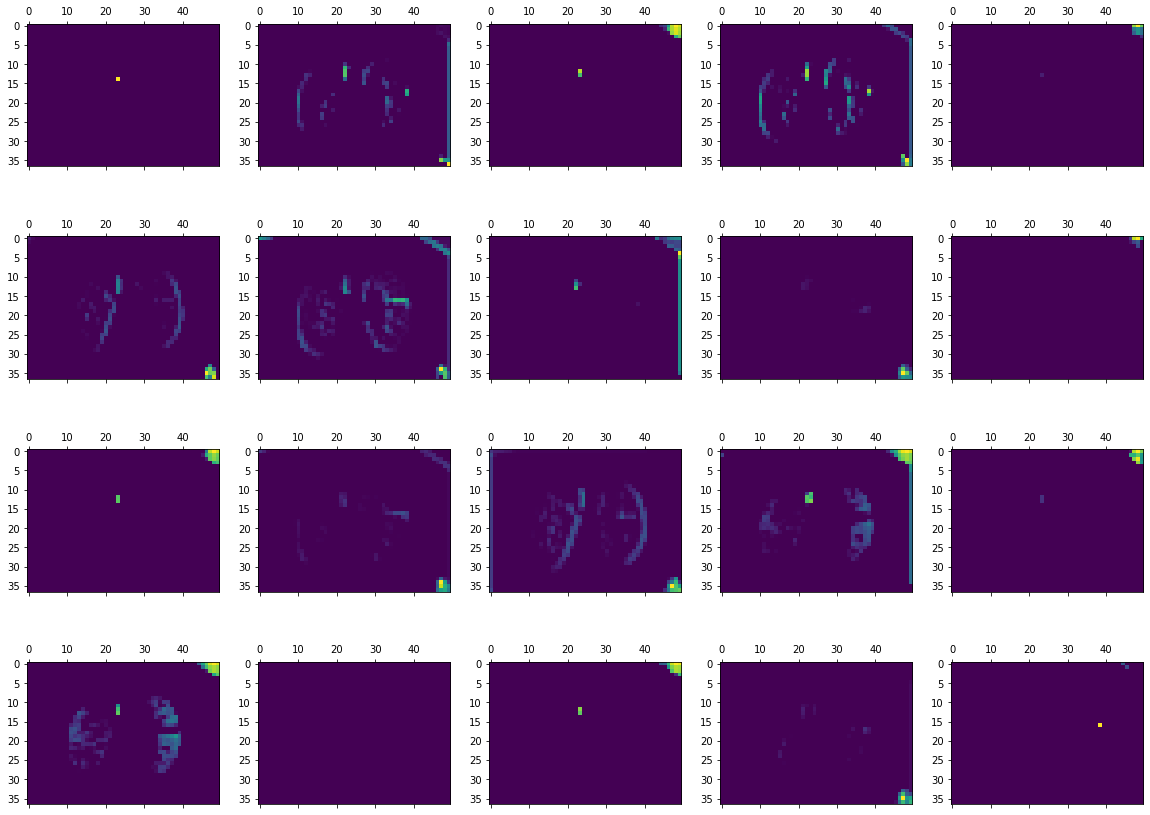

In [26]:
plt.figure(figsize = (20,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.matshow(activations[5][0, :, :, i], cmap = 'viridis', fignum = False)

plt.show();

Let's look with Grad-CAM and Saliency Maps

In [107]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm

In [172]:
# Define loss function
loss = lambda x: K.mean(x[:, 0])

def og_sal_grad(image_id):
    # Define modifier to replace a softmax function of the last layer to a linear function.
    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear

    # Create Saliency object
    saliency = Saliency(model, model_modifier)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss, data_val[image_id].astype(float), smooth_samples=20)
    saliency_map = normalize(saliency_map)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

    img = data_val[image_id,:,:,:]
    img_batch = (np.expand_dims(img,0))

    # from matplotlib import cm
    # from tf_keras_vis.gradcam import Gradcam

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier)

    # Generate heatmap with GradCAM
    cam = gradcam(loss, img_batch.astype(float))
    cam = normalize(cam)


    #Plot
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(np.squeeze(data_val[image_id]), cmap = 'gray')
    plt.subplot(1,3,2)
    plt.title("Saliency Map")
    plt.imshow(saliency_map[0], cmap='YlOrBr');
    plt.subplot(1,3,3)

    
    plt.title("GradCAM")
    for i in range(len(cam)):
        heatmap = np.uint8(tf.cast(cm.jet(cam[i])[..., :3] * 255, tf.float32))
        plt.imshow(np.squeeze(img))
        plt.imshow(heatmap, cmap='YlOrBr', alpha=0.6)

Prediction is: 0


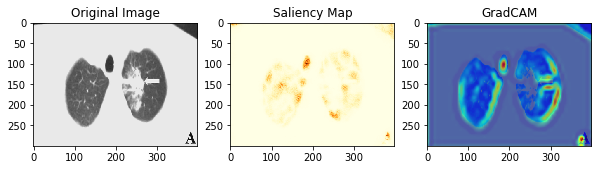

In [173]:
og_sal_grad(1)

#What is the prediction for this image?
predictions_single = model.predict(img_batch)
print(f'Prediction is: {np.argmax(predictions_single[0])}') 